# Imports

In [1]:
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from albumentations import Compose, ShiftScaleRotate, Blur
from albumentations.pytorch import ToTensor

import matplotlib.pyplot as plt
import numpy as np

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
def make_report(y_pred , y_true, fig_size = (20,20)):
    print ("")
    print ("Classification Report: ")
    print (classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plot_confusion_matrix(figsize=fig_size, conf_mat=cm)
    plt.show()

/kaggle/input/traffic-signs-preprocessed/mean_image_rgb.pickle
/kaggle/input/traffic-signs-preprocessed/data5.pickle
/kaggle/input/traffic-signs-preprocessed/data4.pickle
/kaggle/input/traffic-signs-preprocessed/data7.pickle
/kaggle/input/traffic-signs-preprocessed/data8.pickle
/kaggle/input/traffic-signs-preprocessed/data1.pickle
/kaggle/input/traffic-signs-preprocessed/data3.pickle
/kaggle/input/traffic-signs-preprocessed/test.pickle
/kaggle/input/traffic-signs-preprocessed/mean_image_gray.pickle
/kaggle/input/traffic-signs-preprocessed/data6.pickle
/kaggle/input/traffic-signs-preprocessed/data0.pickle
/kaggle/input/traffic-signs-preprocessed/valid.pickle
/kaggle/input/traffic-signs-preprocessed/data2.pickle
/kaggle/input/traffic-signs-preprocessed/labels.pickle
/kaggle/input/traffic-signs-preprocessed/datasets_preparing.py
/kaggle/input/traffic-signs-preprocessed/std_gray.pickle
/kaggle/input/traffic-signs-preprocessed/std_rgb.pickle
/kaggle/input/traffic-signs-preprocessed/label_na

# Loading data

In [2]:
data = pd.read_pickle('/kaggle/input/traffic-signs-preprocessed/data0.pickle')
print('keys:', data.keys())
print('train shape:', data['x_train'].shape)
print('test shape:', data['x_test'].shape)
print('validation shape:', data['x_validation'].shape)

keys: dict_keys(['x_test', 'y_validation', 'x_validation', 'labels', 'x_train', 'y_test', 'y_train'])
train shape: (86989, 3, 32, 32)
test shape: (12630, 3, 32, 32)
validation shape: (4410, 3, 32, 32)


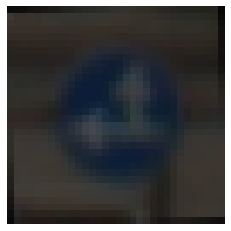

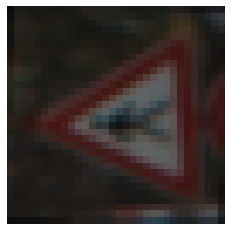

In [3]:
for i in range(2):
    img = data['x_train'][i].T
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [4]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, num_classes):
        self.x = x
        self.y = y
        self.n_class = num_classes

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x=torchvision.transforms.functional.to_tensor(self.x[idx].astype(np.uint8).reshape((32, 32, 3)))
        
        label_idx = self.y[idx]
        label = np.zeros(self.n_class)
        label[label_idx] = 1
        label = torch.tensor(label)
#         return {'x': self.x[idx], 'y': label}
        return {'x': x, 'y': label}
    
BATCH_SIZE = 256    
train_dataset = MyDataset(data['x_train'], data['y_train'], 43)
dataLoader_train = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

test_dataset = MyDataset(data['x_test'], data['y_test'], 43)
dataLoader_test = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True)

validation_dataset = MyDataset(data['x_validation'], data['y_validation'], 43)
dataLoader_validation = torch.utils.data.DataLoader(validation_dataset,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True)

# EDA

(array([2023., 2023., 2023., 2023., 2023., 2023., 2023., 2023., 2023.,
        2023., 2023., 2023., 2023., 2023., 2023., 2023., 2023., 2023.,
        2023., 2023., 2023., 2023., 2023., 2023., 2023., 2023., 2023.,
        2023., 2023., 2023., 2023., 2023., 2023., 2023., 2023., 2023.,
        2023., 2023., 2023., 2023., 2023., 2023., 2023.]),
 array([ 0.        ,  0.97674419,  1.95348837,  2.93023256,  3.90697674,
         4.88372093,  5.86046512,  6.8372093 ,  7.81395349,  8.79069767,
         9.76744186, 10.74418605, 11.72093023, 12.69767442, 13.6744186 ,
        14.65116279, 15.62790698, 16.60465116, 17.58139535, 18.55813953,
        19.53488372, 20.51162791, 21.48837209, 22.46511628, 23.44186047,
        24.41860465, 25.39534884, 26.37209302, 27.34883721, 28.3255814 ,
        29.30232558, 30.27906977, 31.25581395, 32.23255814, 33.20930233,
        34.18604651, 35.1627907 , 36.13953488, 37.11627907, 38.09302326,
        39.06976744, 40.04651163, 41.02325581, 42.        ]),
 <BarContai

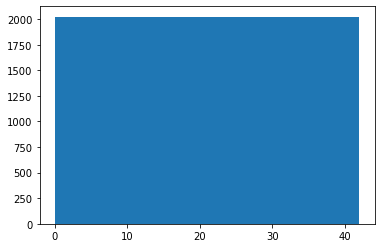

In [5]:
plt.hist(data['y_train'], bins = 43)

so the classes are balanced

# Modeling

In [6]:
class Model(torch.nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
        )
        
        self.flatten = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d(1), torch.nn.Flatten())
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(64, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x) 
        x = self.fc(x)
        return x
    
model = Model(43)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

Model(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Sequential(
    (0): AdaptiveMaxPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=43, bias=True)
  )
)


In [7]:
%%time

n_epochs = 3
print('started!')
for epoch in range(n_epochs):
    train_batch_loss = 0
    model.train()
    for step, batch in enumerate(dataLoader_train):
        x = batch["x"]
        y = batch["y"]

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, torch.max(y, 1)[1])
        loss.backward()
        optimizer.step()
        train_batch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()

    test_batch_loss = 0
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader_test):
            x = batch["x"]
            y = batch["y"]
            outputs = model(x)
            loss = criterion(outputs, torch.max(y, 1)[1])
            test_batch_loss += loss.item()

    print('epoch {}/{} finished with train loss: {} and test loss: {}'.format(epoch+1, n_epochs,
                                                                              train_batch_loss / len(dataLoader_train),
                                                                              test_batch_loss / len(dataLoader_test)))
    
torch.save(model.state_dict(), './model_RGB')

started!
epoch 1/3 finished with train loss: 1.3974241781760663 and test loss: 0.5665107917785644
epoch 2/3 finished with train loss: 0.23308360342155485 and test loss: 0.4760420560836792
epoch 3/3 finished with train loss: 0.14446038695819238 and test loss: 0.44184818983078
CPU times: user 13min 2s, sys: 4min 16s, total: 17min 18s
Wall time: 17min 22s


Test

Classification Report: 
              precision    recall  f1-score   support

           0       0.62      0.63      0.63        60
           1       0.96      0.84      0.90       720
           2       0.95      0.87      0.91       750
           3       0.88      0.95      0.91       450
           4       0.80      0.95      0.87       660
           5       0.86      0.86      0.86       630
           6       0.99      0.82      0.90       150
           7       0.87      0.88      0.88       450
           8       0.86      0.92      0.89       450
           9       0.95      0.95      0.95       480
          10       0.96      0.99      0.97       660
          11       0.91      0.89      0.90       420
          12       0.90      0.93      0.91       690
          13       0.93      0.98      0.95       720
          14       0.98      0.94      0.96       270
          15       0.96      0.94      0.95       210
          16       0.99      0.97      0.98       1

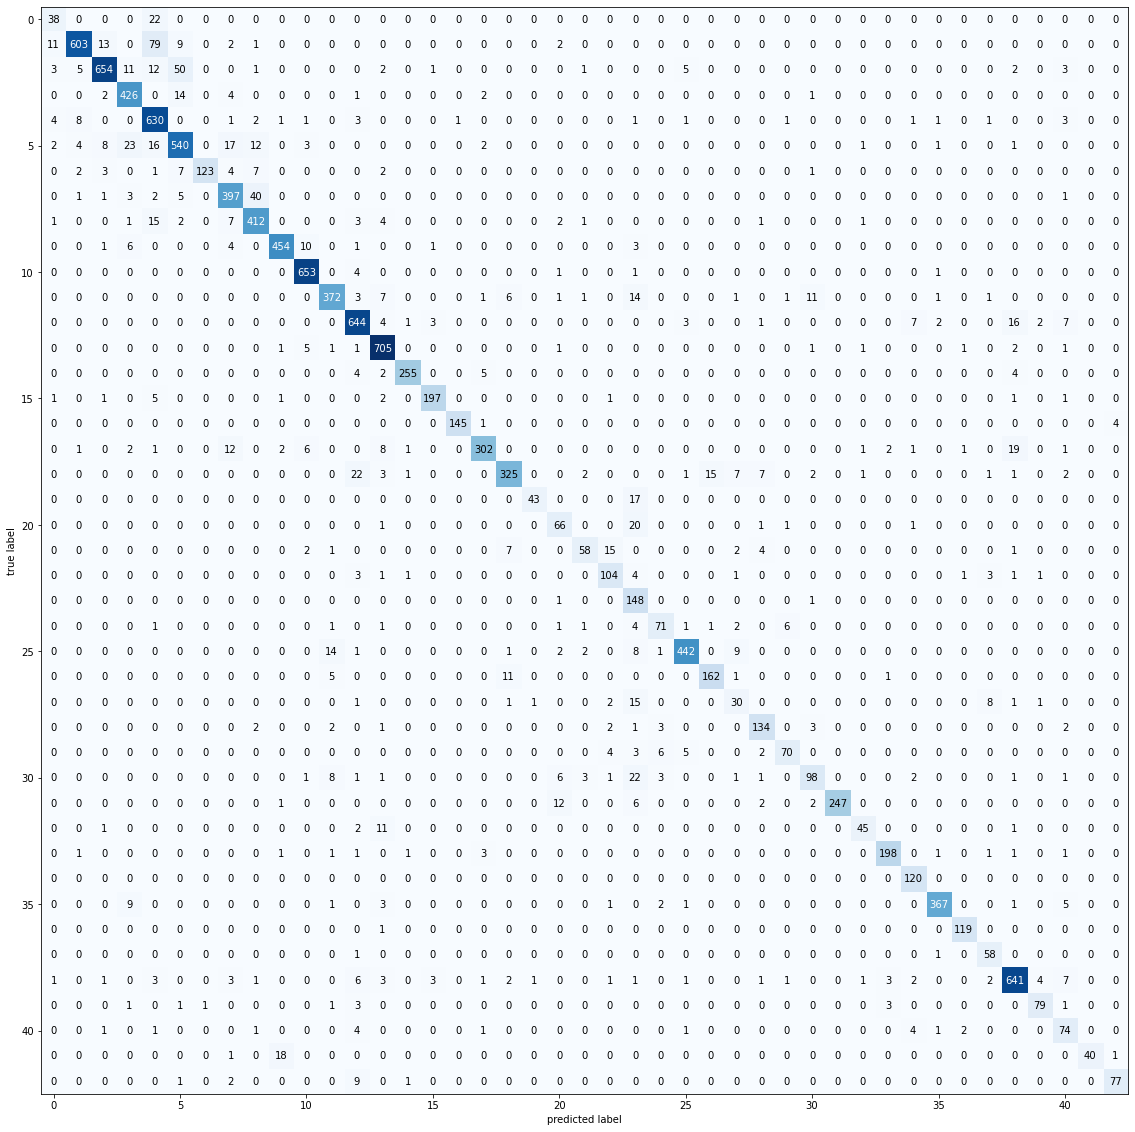

validation

Classification Report: 
              precision    recall  f1-score   support

           0       0.73      0.53      0.62        30
           1       0.98      0.87      0.92       240
           2       0.95      0.89      0.92       240
           3       0.92      0.99      0.95       150
           4       0.84      1.00      0.91       210
           5       0.95      0.93      0.94       210
           6       1.00      0.98      0.99        60
           7       0.90      0.98      0.94       150
           8       0.95      0.95      0.95       150
           9       0.97      0.96      0.96       150
          10       1.00      1.00      1.00       210
          11       0.95      1.00      0.97       150
          12       0.92      1.00      0.96       210
          13       0.96      0.99      0.98       240
          14       0.98      1.00      0.99        90
          15       0.99      0.96      0.97        90
          16       0.97      0.47      0.63  

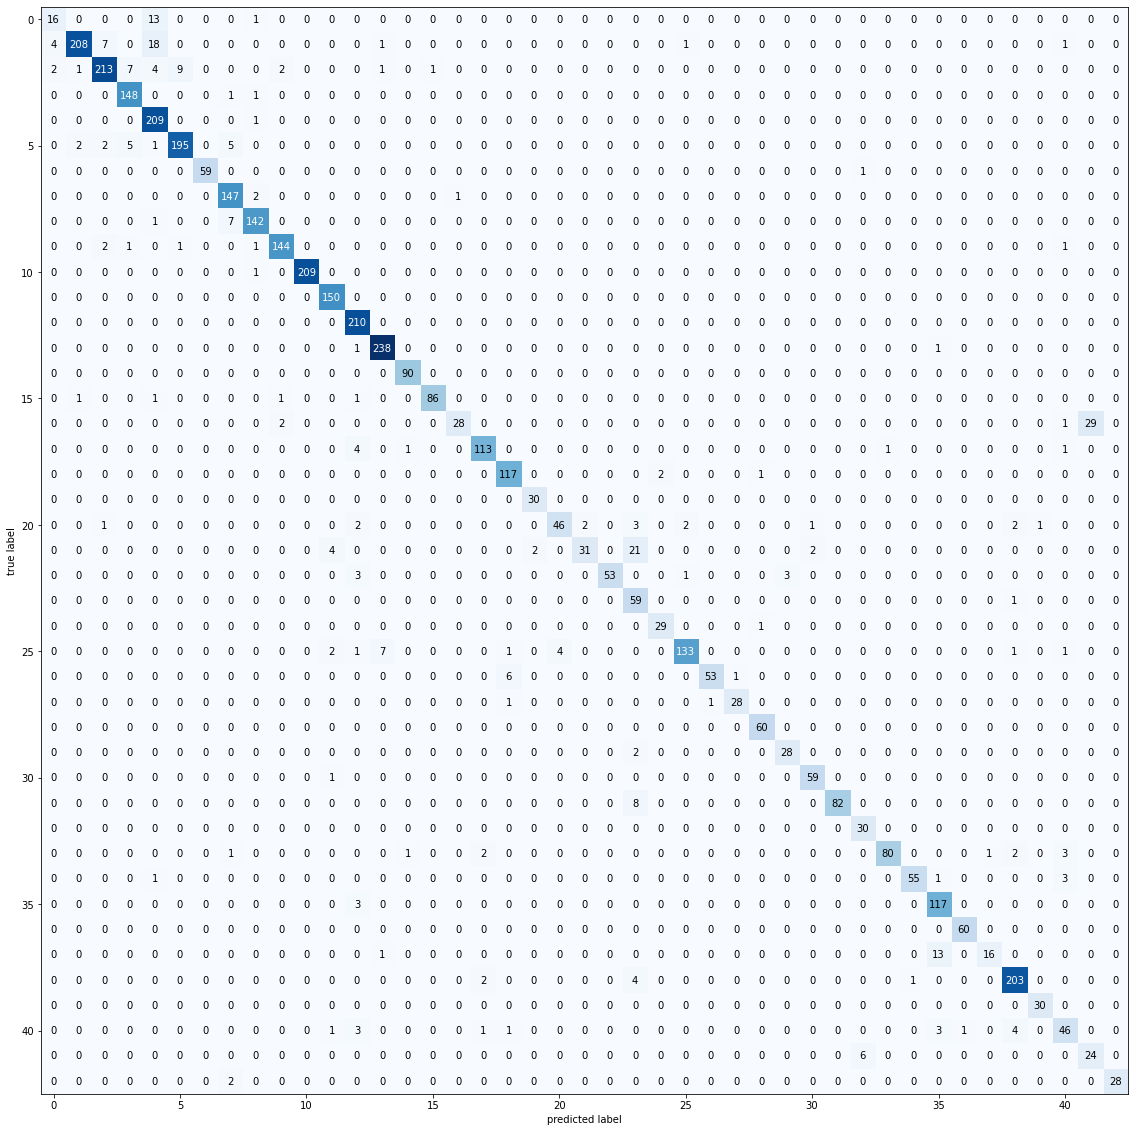

In [8]:
def res(dataLoader):  
    trues = []
    preds = []
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader):
            x = batch["x"]
            y = batch["y"]

            outputs = model(x)

            true_labels = torch.max(y, 1)[1]
            trues = trues + true_labels.tolist()
            pred_labels = torch.max(outputs, 1)[1]
            preds = preds + pred_labels.tolist()


    make_report(y_pred = preds, y_true = trues)

print('Test')
res(dataLoader_test)
print('validation')
res(dataLoader_validation)

# Gray scale 

In [9]:
data = pd.read_pickle('/kaggle/input/traffic-signs-preprocessed/data4.pickle')
print('keys:', data.keys())
print('train shape:', data['x_train'].shape)
print('test shape:', data['x_test'].shape)
print('validation shape:', data['x_validation'].shape)

keys: dict_keys(['y_validation', 'labels', 'x_validation', 'x_test', 'x_train', 'y_train', 'y_test'])
train shape: (86989, 1, 32, 32)
test shape: (12630, 1, 32, 32)
validation shape: (4410, 1, 32, 32)


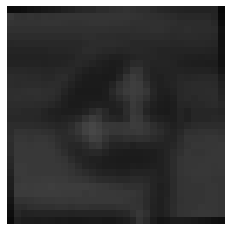

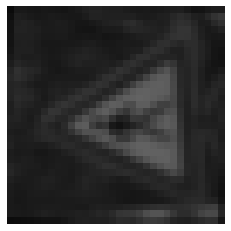

In [10]:
for i in range(2):
    img = data['x_train'][i].T
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.show()

In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, num_classes):
        self.x = x
        self.y = y
        self.n_class = num_classes

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x=torchvision.transforms.functional.to_tensor(self.x[idx].astype(np.uint8).reshape((32, 32, 1)))
        
        label_idx = self.y[idx]
        label = np.zeros(self.n_class)
        label[label_idx] = 1
        label = torch.tensor(label)
#         return {'x': self.x[idx], 'y': label}
        return {'x': x, 'y': label}
    
BATCH_SIZE = 256    
train_dataset = MyDataset(data['x_train'], data['y_train'], 43)
dataLoader_train = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

test_dataset = MyDataset(data['x_test'], data['y_test'], 43)
dataLoader_test = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True)

validation_dataset = MyDataset(data['x_validation'], data['y_validation'], 43)
dataLoader_validation = torch.utils.data.DataLoader(validation_dataset,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True)

In [12]:
# #68 percent
# class Model(torch.nn.Module):
    
#     def __init__(self, num_classes):
#         super().__init__()
        
#         self.conv = torch.nn.Sequential(
#             torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3)),
#             torch.nn.ReLU(),
#             torch.nn.BatchNorm2d(32),
#             torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3)),
#             torch.nn.ReLU(),
#             torch.nn.BatchNorm2d(32),
#         )
        
#         self.flatten = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d(1), torch.nn.Flatten())
        
#         self.fc = torch.nn.Sequential(
#             torch.nn.Linear(32, 256),
#             torch.nn.ReLU(),
#             torch.nn.Dropout(0.3),
#             torch.nn.Linear(256, num_classes)
#         )
        
#     def forward(self, x):
#         x = self.conv(x)
#         x = self.flatten(x) 
#         x = self.fc(x)
#         return x
    
# model = Model(43)
# print(model)
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [13]:
# #81
# class Model(torch.nn.Module):
    
#     def __init__(self, num_classes):
#         super().__init__()
        
#         self.conv = torch.nn.Sequential(
#             torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3)),
#             torch.nn.ReLU(),
#             torch.nn.BatchNorm2d(32),
#             torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
#             torch.nn.ReLU(),
#             torch.nn.BatchNorm2d(64),
#         )
        
#         self.flatten = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d(1), torch.nn.Flatten())
        
#         self.fc = torch.nn.Sequential(
#             torch.nn.Linear(64, 512),
#             torch.nn.ReLU(),
#             torch.nn.Linear(512, num_classes)
#         )
        
#     def forward(self, x):
#         x = self.conv(x)
#         x = self.flatten(x) 
#         x = self.fc(x)
#         return x
    
# model = Model(43)
# print(model)
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [14]:
#90
class Model(torch.nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
        )
        
        self.flatten = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d(1), torch.nn.Flatten())
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(64, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x) 
        x = self.fc(x)
        return x
    
model = Model(43)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

Model(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Sequential(
    (0): AdaptiveMaxPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=43, bias=True)
  )
)


In [15]:
%%time

n_epochs = 3
print('started!')
for epoch in range(n_epochs):
    train_batch_loss = 0
    model.train()
    for step, batch in enumerate(dataLoader_train):
        x = batch["x"]
        y = batch["y"]

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, torch.max(y, 1)[1])
        loss.backward()
        optimizer.step()
        train_batch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()

    test_batch_loss = 0
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader_test):
            x = batch["x"]
            y = batch["y"]
            outputs = model(x)
            loss = criterion(outputs, torch.max(y, 1)[1])
            test_batch_loss += loss.item()

    print('epoch {}/{} finished with train loss: {} and test loss: {}'.format(epoch+1, n_epochs,
                                                                              train_batch_loss / len(dataLoader_train),
                                                                              test_batch_loss / len(dataLoader_test)))
    
torch.save(model.state_dict(), './model_gray')

started!
epoch 1/3 finished with train loss: 1.6667581325944731 and test loss: 0.5931611102819443
epoch 2/3 finished with train loss: 0.2432233651771265 and test loss: 0.44163074910640715
epoch 3/3 finished with train loss: 0.13897608818815035 and test loss: 0.47027438521385195
CPU times: user 12min 56s, sys: 4min 43s, total: 17min 39s
Wall time: 17min 42s


Test

Classification Report: 
              precision    recall  f1-score   support

           0       0.42      1.00      0.59        60
           1       0.93      0.88      0.90       720
           2       0.96      0.95      0.95       750
           3       0.96      0.92      0.94       450
           4       0.93      0.93      0.93       660
           5       0.90      0.90      0.90       630
           6       0.99      0.80      0.89       150
           7       0.92      0.92      0.92       450
           8       0.90      0.91      0.90       450
           9       0.95      0.94      0.94       480
          10       0.97      0.91      0.94       660
          11       0.98      0.85      0.91       420
          12       0.84      0.94      0.89       690
          13       0.94      0.92      0.93       720
          14       0.93      0.94      0.93       270
          15       0.95      0.95      0.95       210
          16       0.99      0.99      0.99       1

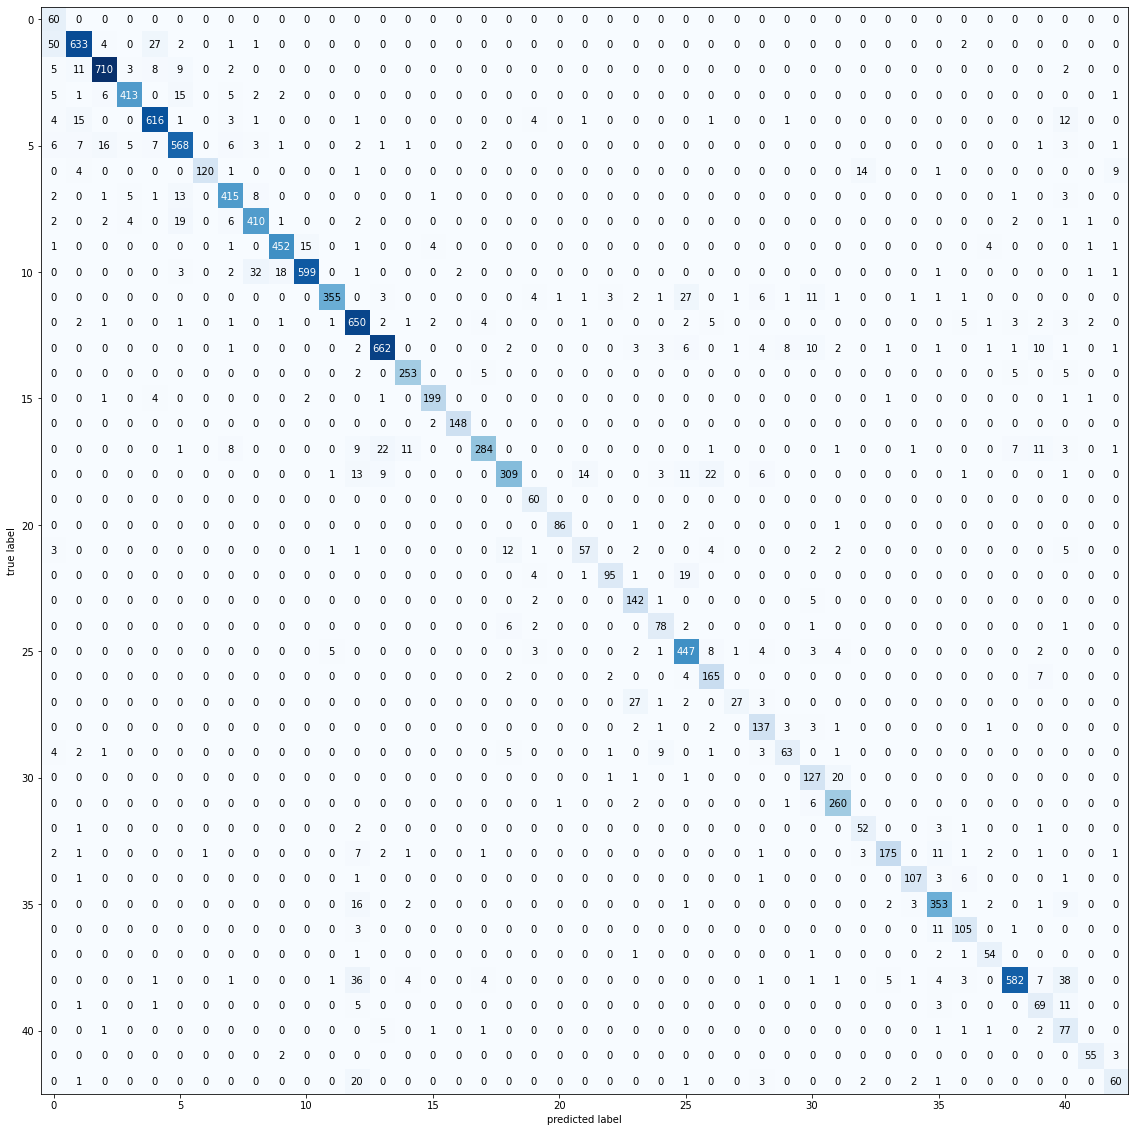

validation

Classification Report: 
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        30
           1       0.95      0.90      0.93       240
           2       0.97      0.96      0.97       240
           3       0.99      0.97      0.98       150
           4       0.95      0.96      0.96       210
           5       0.91      0.93      0.92       210
           6       0.98      0.97      0.97        60
           7       0.99      0.98      0.98       150
           8       0.96      0.95      0.95       150
           9       0.99      0.96      0.97       150
          10       0.99      0.99      0.99       210
          11       0.97      0.96      0.97       150
          12       0.83      0.95      0.88       210
          13       0.93      0.94      0.94       240
          14       0.90      0.92      0.91        90
          15       0.97      1.00      0.98        90
          16       0.97      0.50      0.66  

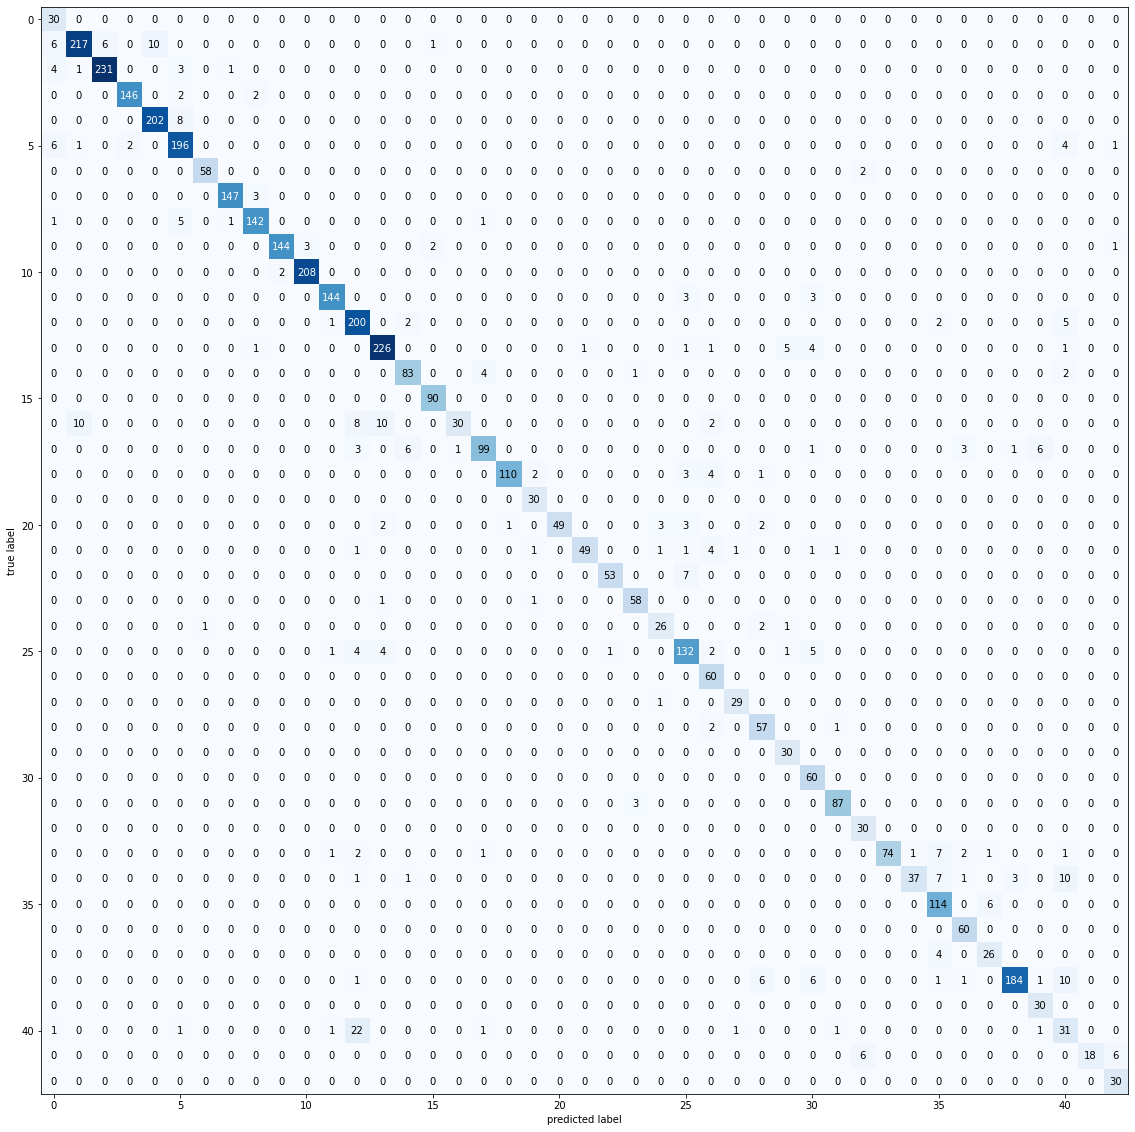

In [16]:
def res(dataLoader):  
    trues = []
    preds = []
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader):
            x = batch["x"]
            y = batch["y"]

            outputs = model(x)

            true_labels = torch.max(y, 1)[1]
            trues = trues + true_labels.tolist()
            pred_labels = torch.max(outputs, 1)[1]
            preds = preds + pred_labels.tolist()


    make_report(y_pred = preds, y_true = trues)

print('Test')
res(dataLoader_test)
print('validation')
res(dataLoader_validation)

# Visualization of filters and outputs

In [17]:
model = Model(43)
model.load_state_dict(torch.load('./model_gray'))

<All keys matched successfully>

layer1
-------------------------------------------------------------


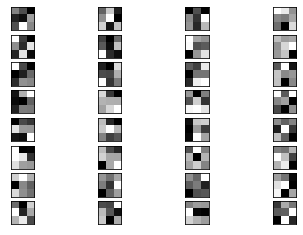

layer2
-------------------------------------------------------------


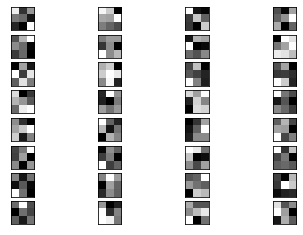

layer3
-------------------------------------------------------------


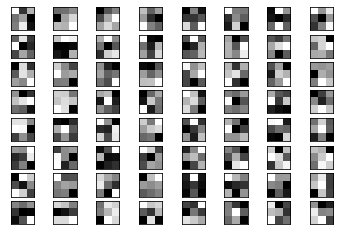

In [18]:
model.conv[0]
def imshow_filter(img,row,col):
    print('-------------------------------------------------------------')
    plt.figure()
    for i in range(len(filters)):
        img = filters[i]
        img = np.transpose(img, (1, 2, 0))
        img = img/(img.max()-img.min())
        plt.subplot(row,col,i+1)
        plt.imshow(img,cmap= 'gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

print('layer1')
filters = model.conv[0].weight.data.cpu().numpy()
imshow_filter(filters,8, 4)

print('layer2')
filters = model.conv[3].weight.data.cpu().numpy()[:,0:1,:,:]
imshow_filter(filters,8, 4)

print('layer3')
filters = model.conv[6].weight.data.cpu().numpy()[:,0:1,:,:]
imshow_filter(filters,8, 8)

## outputs 

In [19]:
#90
class VizModel(torch.nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
        )
        
        self.flatten = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d(1), torch.nn.Flatten())
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(64, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        for layer in self.conv:
            x = layer(x)
            for i in range(16):
                img = x.detach().numpy()[0,i:i+1,:,:]
                img = np.transpose(img, (1, 2, 0))
                img = img/(img.max()-img.min())+0.001
                plt.subplot(8,4,i+1)
                plt.imshow(img,cmap= 'gray')
                plt.xticks([])
                plt.yticks([])
            plt.savefig('./{}.jpg'.format(layer))
            plt.show()

        x = self.flatten(x) 
        x = self.fc(x)
        return x

model = VizModel(43)
model.load_state_dict(torch.load('./model_gray'))

<All keys matched successfully>

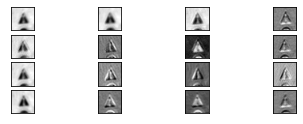

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/opt/conda/lib/python3.7/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/opt/conda/lib/python3.7/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


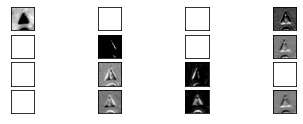

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


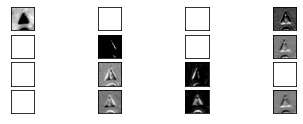

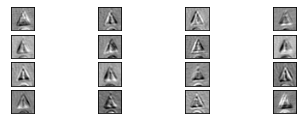

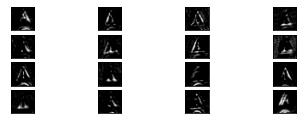

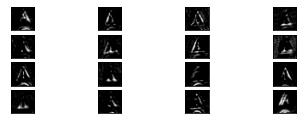

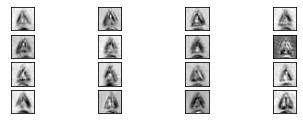

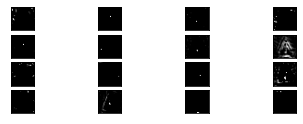

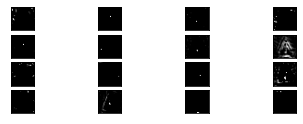

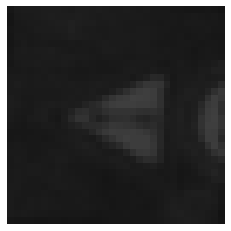

In [20]:
a = next(iter(dataLoader_train))
x = a['x'][4:5,:,:,:]
model(x)

img = x[0,:,:,:].T
plt.imshow(img, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.savefig('./sign.jpg')
plt.show()

# data Augmentation

In [21]:
data = pd.read_pickle('/kaggle/input/traffic-signs-preprocessed/data4.pickle')
print('keys:', data.keys())
print('train shape:', data['x_train'].shape)
print('test shape:', data['x_test'].shape)
print('validation shape:', data['x_validation'].shape)

keys: dict_keys(['y_validation', 'labels', 'x_validation', 'x_test', 'x_train', 'y_train', 'y_test'])
train shape: (86989, 1, 32, 32)
test shape: (12630, 1, 32, 32)
validation shape: (4410, 1, 32, 32)


In [22]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, num_classes, transform = None):
        self.x = x
        self.y = y
        self.n_class = num_classes
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
#         x=torchvision.transforms.functional.to_tensor(self.x.astype(np.uint8).reshape((32, 32, 1)))
        
        augmented = self.transform(image=self.x[idx].reshape((32, 32, 1)))
        x = augmented['image']
#         print(x.shape)
        label_idx = self.y[idx]
        label = np.zeros(self.n_class)
        label[label_idx] = 1
        label = torch.tensor(label)
#         return {'x': self.x[idx], 'y': label}
        return {'x': x, 'y': label}

transform_train = Compose([
    Blur(blur_limit=3, p=0.1),
    ShiftScaleRotate(rotate_limit=45, p=0.3),
    ToTensor()
])

transform_test = Compose([
    ToTensor()
])
    
BATCH_SIZE = 256    
train_dataset = MyDataset(data['x_train'], data['y_train'], 43, transform = transform_train)
dataLoader_train = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

test_dataset = MyDataset(data['x_test'], data['y_test'], 43, transform = transform_test)
dataLoader_test = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True)

validation_dataset = MyDataset(data['x_validation'], data['y_validation'], 43,transform = transform_test)
dataLoader_validation = torch.utils.data.DataLoader(validation_dataset,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True)

In [23]:
#90
class Model(torch.nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
        )
        
        self.flatten = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d(1), torch.nn.Flatten())
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(64, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x) 
        x = self.fc(x)
        return x
    
model = Model(43)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

Model(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Sequential(
    (0): AdaptiveMaxPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=43, bias=True)
  )
)


In [24]:
%%time

n_epochs = 3
print('started!')
for epoch in range(n_epochs):
    train_batch_loss = 0
    model.train()
    for step, batch in enumerate(dataLoader_train):
        x = batch["x"]
        y = batch["y"]

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, torch.max(y, 1)[1])
        loss.backward()
        optimizer.step()
        train_batch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()

    test_batch_loss = 0
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader_test):
            x = batch["x"]
            y = batch["y"]
            outputs = model(x)
            loss = criterion(outputs, torch.max(y, 1)[1])
            test_batch_loss += loss.item()

    print('epoch {}/{} finished with train loss: {} and test loss: {}'.format(epoch+1, n_epochs,
                                                                              train_batch_loss / len(dataLoader_train),
                                                                              test_batch_loss / len(dataLoader_test)))
    
torch.save(model.state_dict(), './model_aug')

started!
epoch 1/3 finished with train loss: 2.012197048173231 and test loss: 0.8754879534244537
epoch 2/3 finished with train loss: 0.5425010838929345 and test loss: 0.5640675020217896
epoch 3/3 finished with train loss: 0.3633884840151843 and test loss: 0.48768347382545474
CPU times: user 12min 53s, sys: 4min 49s, total: 17min 42s
Wall time: 17min 46s


Test

Classification Report: 
              precision    recall  f1-score   support

           0       0.48      0.97      0.64        60
           1       0.92      0.92      0.92       720
           2       0.91      0.93      0.92       750
           3       0.96      0.82      0.88       450
           4       0.96      0.92      0.94       660
           5       0.86      0.88      0.87       630
           6       0.81      0.99      0.89       150
           7       0.98      0.85      0.91       450
           8       0.88      0.95      0.91       450
           9       0.99      0.92      0.95       480
          10       0.98      0.94      0.96       660
          11       0.96      0.79      0.87       420
          12       0.91      0.91      0.91       690
          13       0.81      0.94      0.87       720
          14       0.91      0.86      0.88       270
          15       0.76      0.94      0.84       210
          16       0.98      0.98      0.98       1

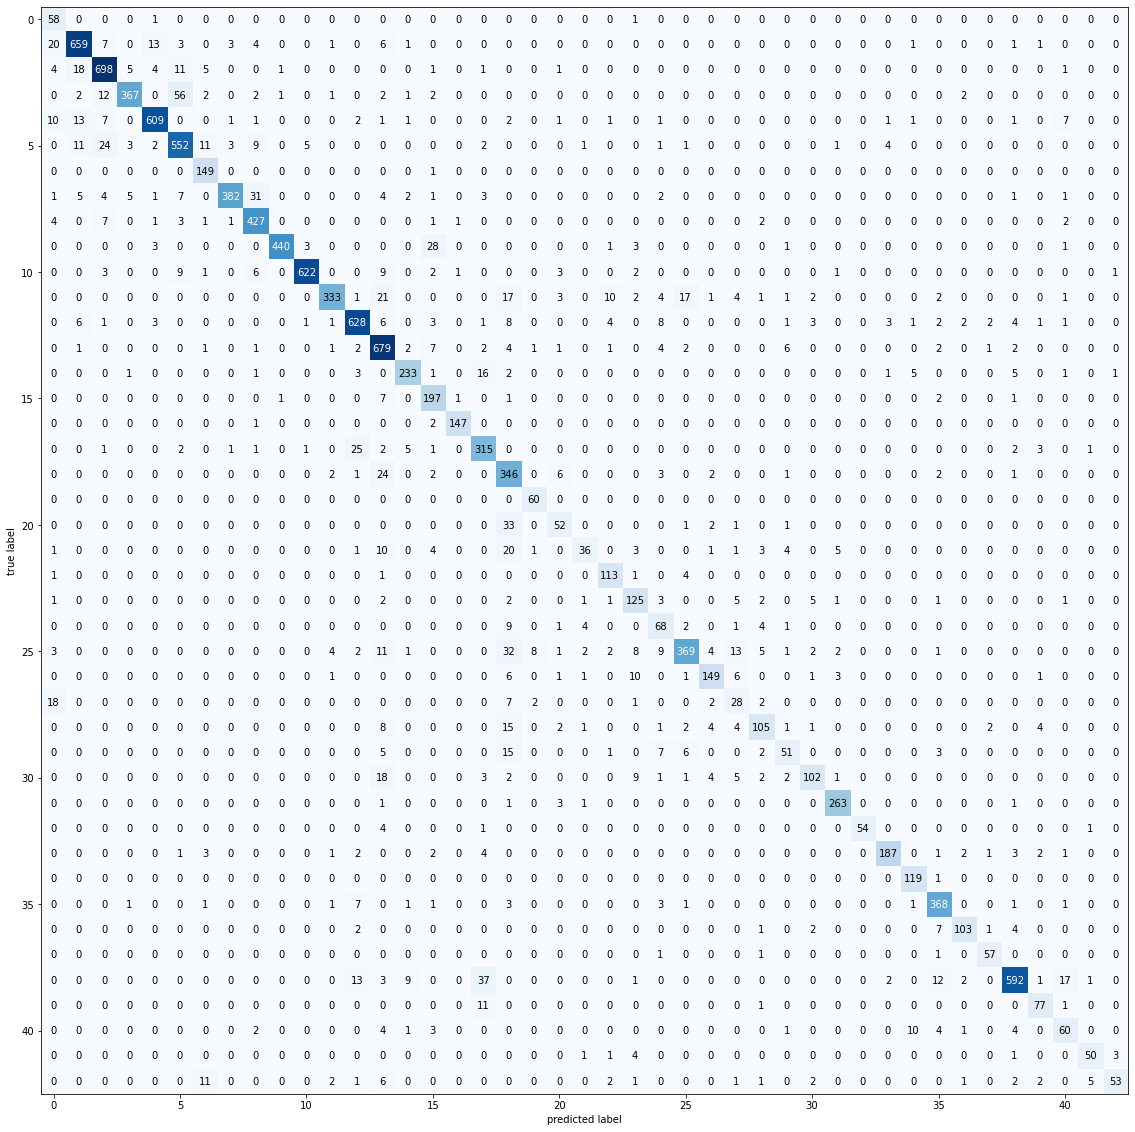

validation

Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.97      0.87        30
           1       0.95      0.90      0.93       240
           2       0.96      0.98      0.97       240
           3       0.96      0.94      0.95       150
           4       0.92      1.00      0.96       210
           5       0.94      0.97      0.95       210
           6       0.95      1.00      0.98        60
           7       0.99      0.91      0.95       150
           8       0.96      0.95      0.95       150
           9       0.99      0.99      0.99       150
          10       1.00      1.00      1.00       210
          11       0.97      0.99      0.98       150
          12       0.80      0.90      0.85       210
          13       0.82      0.97      0.89       240
          14       0.93      0.93      0.93        90
          15       0.96      0.99      0.97        90
          16       1.00      0.52      0.68  

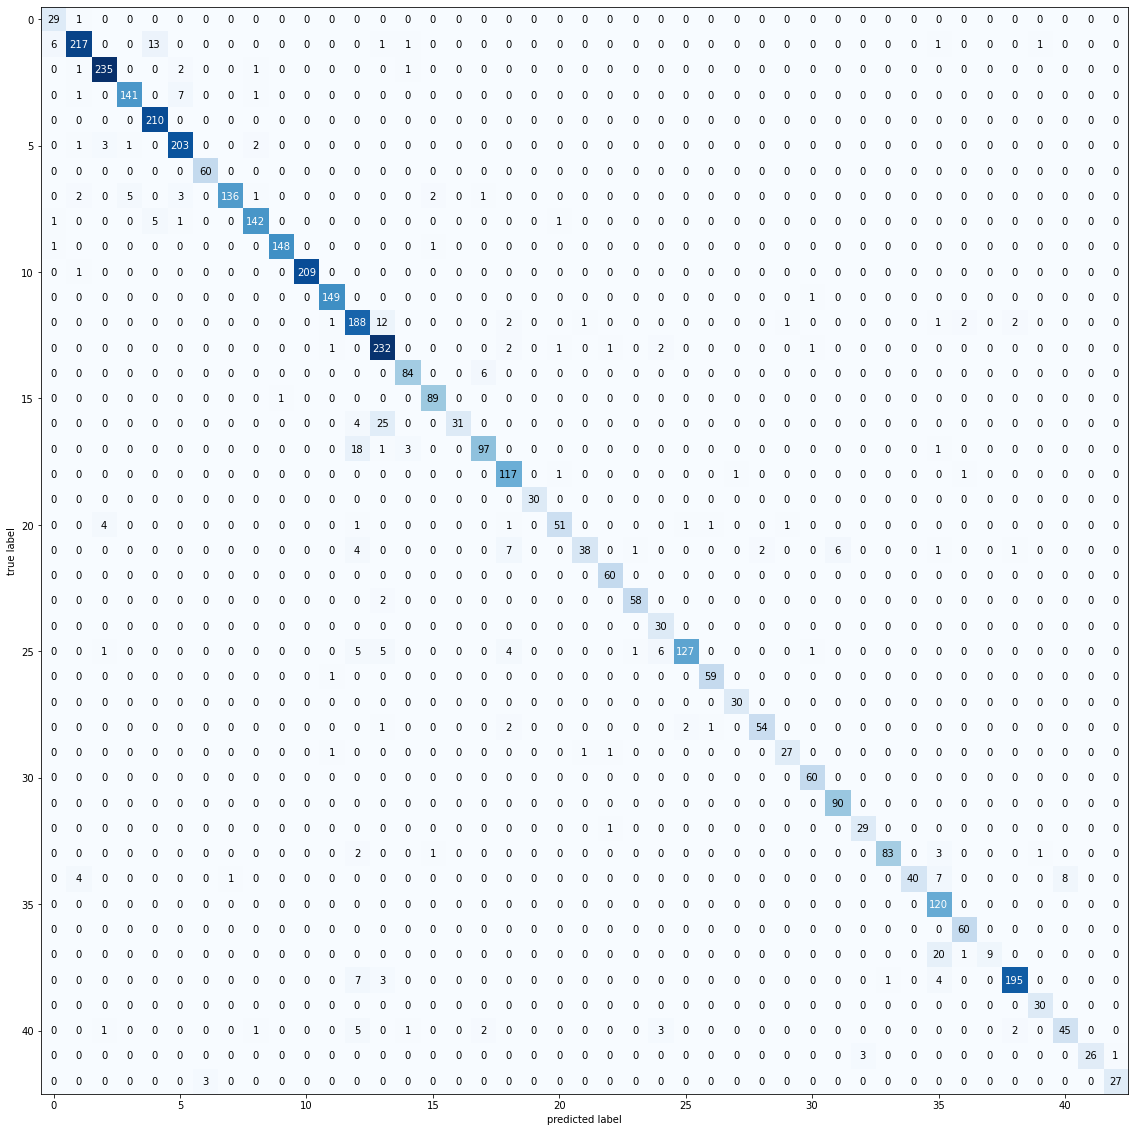

In [25]:
def res(dataLoader):  
    trues = []
    preds = []
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader):
            x = batch["x"]
            y = batch["y"]

            outputs = model(x)

            true_labels = torch.max(y, 1)[1]
            trues = trues + true_labels.tolist()
            pred_labels = torch.max(outputs, 1)[1]
            preds = preds + pred_labels.tolist()


    make_report(y_pred = preds, y_true = trues)

print('Test')
res(dataLoader_test)
print('validation')
res(dataLoader_validation)